In [214]:
import pickle
import pandas as pd
import numpy as np
import boto3
import botocore
from IPython.display import clear_output
import seaborn as sns
import glob

In [30]:
def get_all_s3_keys(**kwargs):
    keys = []
    while True:
        resp = s3.list_objects_v2(**kwargs)
        if 'Contents' in resp:
            for obj in resp['Contents']:
                keys.append(obj['Key'])
        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break
    return keys

In [220]:
df = pd.read_csv('data-2020-06-16T22_59_09.061Z.csv')

In [221]:
def convert(c, d):
    def cc(v):
        try:
            return c(v)
        except:
            return d
    return cc

df['participant'] = df.Identifiers.apply(lambda r: r.split(',')[0].strip())
df['session'] = df.Identifiers.apply(lambda r: r.split(',')[1].strip())
df['age'] = df.age_04.apply(lambda f: float(f) if f != '.' else 0.0)
df['sex'] = df.dem_002.apply(convert(lambda x: {'1': 'M', '2': 'F'}[x], np.nan))

In [222]:
# remove non-numeric 
df = df[pd.to_numeric(df['dem_002'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['dbdi_22'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['gdsc_31'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['cogfq_26'], errors='coerce').notnull()]


In [223]:
df['height'] = df.height_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['weight'] = df.weight_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['v02max'] = df.v02max.apply(lambda f: float(f) if f != '.' else 0.0)
df['height'] = df.height_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['med'] = df.med_20.apply(lambda f: float(f) if f != '.' else 0.0)
df['med_v2'] = df['dsmeds_00'].apply(lambda f: float(f) if f != '.' else 0.0)

df['moca'] = df.moca_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['wasi'] = df.int_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['bdi'] = df.dbdi_22.apply(lambda f: float(f) if f != '.' else 0.0)
df['gds'] = df.gdsc_31.apply(lambda f: float(f) if f != '.' else 0.0)
df['dkefs'] = df.dkefstmt_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['cfq'] = df.cogfq_26.apply(lambda f: float(f) if f != '.' else 0.0)

df['bp_sys'] = df.vit_06.apply(lambda f: float(f) if f != '.' else 0.0)
df['bp_dys'] = df.vit_07.apply(lambda f: float(f) if f != '.' else 0.0)



In [13]:
s3 = boto3.client('s3')

In [ ]:
objs = get_all_s3_keys(Bucket='fcp-indi', Prefix='data/Projects/RocklandSample/RawDataBIDSLatest')

In [ ]:
subject_files = list(filter(lambda x: x.startswith('data/Projects/RocklandSample/RawDataBIDSLatest/sub-'), objs))
subject_files = [s[47:] for s in subject_files]

In [ ]:
# 3D MP-RAGE
# rs fMRI
# DTI
# Cerebral Blood Flow
# Breath Hold ASL
# Perfusion ASL
# Both Breath Hold & Perfusion ASL

def has_anat(r):
    return f'sub-{r.participant}/ses-{r.session}/anat/sub-{r.participant}_ses-{r.session}_T1w.nii.gz' in subject_files

def has_rest(r):
    return f'sub-{r.participant}/ses-{r.session}/func/sub-{r.participant}_ses-{r.session}_task-rest_acq-1400_bold.nii.gz' in subject_files

def has_dti(r):
    return f'sub-{r.participant}/ses-{r.session}/dwi/sub-{r.participant}_ses-{r.session}_dwi.nii.gz' in subject_files

def has_asl(r):
    return f'sub-{r.participant}/ses-{r.session}/func/sub-{r.participant}_ses-{r.session}_task-pCASL_bold.nii.gz' in subject_files

def has_breathhold(r):
    return f'sub-{r.participant}/ses-{r.session}/func/sub-{r.participant}_ses-{r.session}_task-BREATHHOLD_acq-1400_bold.nii.gz' in subject_files

df['anat'] = df.apply(has_anat, axis=1)
df['rest'] = df.apply(has_rest, axis=1)
df['dti'] = df.apply(has_dti, axis=1)
df['asl'] = df.apply(has_asl, axis=1)
df['breathhold'] = df.apply(has_breathhold, axis=1)

In [ ]:
checks = ['anat', 'rest', 'dti', 'asl', 'breathhold']

In [ ]:
def print_stats(df):
    print(f"{np.sum(df.anat)}\t{np.sum(df[df.sex == 'M'].anat)}\t{np.sum(df[df.sex == 'F'].anat)}")
    print(f"{np.sum(df.rest)}\t{np.sum(df[df.sex == 'M'].rest)}\t{np.sum(df[df.sex == 'F'].rest)}")
    print(f"{np.sum(df.dti)}\t{np.sum(df[df.sex == 'M'].dti)}\t{np.sum(df[df.sex == 'F'].dti)}")
    print()
    print(f"{np.sum(df.asl)}\t{np.sum(df[df.sex == 'M'].asl)}\t{np.sum(df[df.sex == 'F'].asl)}")
    print(f"{np.sum(df.breathhold)}\t{np.sum(df[df.sex == 'M'].breathhold)}\t{np.sum(df[df.sex == 'F'].breathhold)}")
    print(f"{np.sum((df.asl & df.breathhold))}\t{np.sum((df.asl & df.breathhold)[df.sex == 'M'])}\t{np.sum((df.asl & df.breathhold)[df.sex == 'F'])}")
    print("------------------------------")

In [ ]:
sdf = df \
    [['participant', 'sex'] + checks] \
    .groupby('participant') \
    .agg({
        **{c: lambda x: np.sum(x.values, dtype=bool) for c in checks},
        'sex': 'max'
    })

print_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex'] + checks] \
    .groupby('participant') \
    .agg({
        **{c: lambda x: np.sum(x.values, dtype=bool) for c in checks},
        'sex': 'max'
    })

print_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('FLU')] \
    [['participant', 'sex'] + checks] \
    .groupby('participant') \
    .agg({
        **{c: lambda x: np.sum(x.values, dtype=bool) for c in checks},
        'sex': 'max'
    })

print_stats(sdf)

In [136]:
def print_clinical_stats(df):
    print()
    print()
    print(f"{np.sum(df.height > 0.0)}\t{np.sum(df[df.sex == 'M'].height > 0.0)}\t{np.sum(df[df.sex == 'F'].height > 0.0)}")
    print(f"{np.sum(df.weight > 0.0)}\t{np.sum(df[df.sex == 'M'].weight > 0.0)}\t{np.sum(df[df.sex == 'F'].weight > 0.0)}")
    print(f"{np.sum(df.med > 0.0)}\t{np.sum(df[df.sex == 'M'].med > 0.0)}\t{np.sum(df[df.sex == 'F'].med > 0.0)}")
    print(f"{np.sum(df.med_v2 > 0.0)}\t{np.sum(df[df.sex == 'M'].med_v2 > 0.0)}\t{np.sum(df[df.sex == 'F'].med_v2 > 0.0)}")
    print(f"{np.sum(df.v02max > 0.0)}\t{np.sum(df[df.sex == 'M'].v02max > 0.0)}\t{np.sum(df[df.sex == 'F'].v02max > 0.0)}")
    print("------------------------------")

In [137]:
sdf = df \
    [['participant', 'sex', 'height', 'weight', 'med', 'med_v2', 'v02max']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'height': 'max',
        'weight': 'max',
        'med': 'max',
        'med_v2': 'max',
        'v02max': 'max',
    })

print_clinical_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex', 'height', 'weight', 'med', 'med_v2','v02max']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'height': 'max',
        'weight': 'max',
        'med': 'max',
        'med_v2': 'max',
        'v02max': 'max',
    })

print_clinical_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('FLU')] \
    [['participant', 'sex', 'height', 'weight', 'med', 'med_v2','v02max']] \
    .groupby('participant') \
    .agg({
        'sex': ['mean','std'],
        'height': ['mean','std'],
        'weight': ['mean','std'],
        'med': ['mean','std'],
        'med_v2': ['mean','std'],
        'v02max': ['mean','std'],
    })

print_clinical_stats(sdf)



313	94	219
313	94	219
116	42	74
815	290	525
313	94	219
------------------------------


273	80	193
273	80	193
84	28	56
557	166	391
273	80	193
------------------------------


262	78	184
262	78	184
0	0	0
240	69	171
260	78	182
------------------------------


In [148]:
def print_neurocog_stats(df):
    print()
    print()
    print(f"{np.sum(df.moca > 0.0)}\t{np.sum(df[df.sex == 'M'].moca > 0.0)}\t{np.sum(df[df.sex == 'F'].moca > 0.0)}")
    print(f"{np.sum(df.wasi > 0.0)}\t{np.sum(df[df.sex == 'M'].wasi > 0.0)}\t{np.sum(df[df.sex == 'F'].wasi > 0.0)}")
    print(f"{np.sum(df.bdi > 0.0)}\t{np.sum(df[df.sex == 'M'].bdi > 0.0)}\t{np.sum(df[df.sex == 'F'].bdi > 0.0)}")
    print(f"{np.sum(df.gds > 0.0)}\t{np.sum(df[df.sex == 'M'].gds > 0.0)}\t{np.sum(df[df.sex == 'F'].gds > 0.0)}")
    print(f"{np.sum(df.dkefs > 0.0)}\t{np.sum(df[df.sex == 'M'].dkefs > 0.0)}\t{np.sum(df[df.sex == 'F'].dkefs > 0.0)}")
    print(f"{np.sum(df.cfq > 0.0)}\t{np.sum(df[df.sex == 'M'].cfq > 0.0)}\t{np.sum(df[df.sex == 'F'].cfq > 0.0)}")
    print("------------------------------")

In [149]:
sdf = df \
    [['participant', 'sex', 'moca', 'wasi', 'bdi', 'gds', 'dkefs', 'cfq']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'moca': 'max',
        'wasi': 'max',
        'bdi': 'max',
        'gds': 'max',
        'dkefs': 'max',
        'cfq': 'max',
    })

print_neurocog_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex', 'moca', 'wasi', 'bdi', 'gds', 'dkefs', 'cfq']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'moca': 'max',
        'wasi': 'max',
        'bdi': 'max',
        'gds': 'max',
        'dkefs': 'max',
        'cfq': 'max',
    })

print_neurocog_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('FLU')] \
    [['participant', 'sex', 'moca', 'wasi', 'bdi', 'gds', 'dkefs', 'cfq']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'moca': 'max',
        'wasi': 'max',
        'bdi': 'max',
        'gds': 'max',
        'dkefs': 'max',
        'cfq': 'max',
    })

print_neurocog_stats(sdf)



92	39	53
93	39	54
81	35	46
80	34	46
85	36	49
93	39	54
------------------------------


74	31	43
74	31	43
62	26	36
62	26	36
75	31	44
75	31	44
------------------------------


70	29	41
72	29	43
61	26	35
53	21	32
49	22	27
73	29	44
------------------------------


In [155]:
def print_female_stats(df):
    print()
    print()
    print(f"{np.sum(df.mham_097 > 0.0)}\t{np.sum(df[df.sex == 'M'].mham_097 > 0.0)}\t{np.sum(df[df.sex == 'F'].mham_097 > 0.0)}")
    print(f"{np.sum(df.mham_098 > 0.0)}\t{np.sum(df[df.sex == 'M'].mham_098 > 0.0)}\t{np.sum(df[df.sex == 'F'].mham_098 > 0.0)}")
    print(f"{np.sum(df.mham_099 > 0.0)}\t{np.sum(df[df.sex == 'M'].mham_099 > 0.0)}\t{np.sum(df[df.sex == 'F'].mham_099 > 0.0)}")
    print(f"{np.sum(df.mham_103 > 0.0)}\t{np.sum(df[df.sex == 'M'].mham_103 > 0.0)}\t{np.sum(df[df.sex == 'F'].mham_103 > 0.0)}")
    print("------------------------------")

In [156]:
df = df[pd.to_numeric(df['mham_097'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['mham_098'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['mham_099'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['mham_103'], errors='coerce').notnull()]

df['mham_097'] = df.mham_097.apply(lambda f: float(f) if f != '.' else 0.0)
df['mham_098'] = df.mham_098.apply(lambda f: float(f) if f != '.' else 0.0)
df['mham_099'] = df.mham_099.apply(lambda f: float(f) if f != '.' else 0.0)
df['mham_103'] = df.mham_103.apply(lambda f: float(f) if f != '.' else 0.0)

sdf = df \
    [['participant', 'sex', 'mham_097', 'mham_098', 'mham_099', 'mham_103']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'mham_097': 'max',
        'mham_098': 'max',
        'mham_099': 'max',
        'mham_103': 'max',
    })

print_female_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex', 'mham_097', 'mham_098', 'mham_099', 'mham_103']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'mham_097': 'max',
        'mham_098': 'max',
        'mham_099': 'max',
        'mham_103': 'max',
    })

print_female_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('FLU')] \
    [['participant', 'sex', 'mham_097', 'mham_098', 'mham_099', 'mham_103']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'mham_097': 'max',
        'mham_098': 'max',
        'mham_099': 'max',
        'mham_103': 'max',
    })

print_female_stats(sdf)



46	0	46
46	0	46
46	0	46
46	0	46
------------------------------


36	0	36
36	0	36
36	0	36
36	0	36
------------------------------


39	0	39
39	0	39
39	0	39
39	0	39
------------------------------


In [138]:
np.sum(df.height > 0)

692

In [145]:
np.sum(df[['participant', 'height']].groupby('participant').mean().height > 0)

313

In [155]:
def count_derivatives(files, start_at=8):
    count = {}
    for i, o in enumerate(files):
        if '/qc/' in o:
            continue
        o = o.strip('/')
        subses, derivative, *iterables, file = o.split('/')[start_at:]
        count[derivative] = count.get(derivative, []) + [subses]
        
        if (i+1) % 10000 == 0:
            clear_output(wait=True)
            print(f'{i+1} of {len(files)}')
    return count

In [147]:
objs = get_all_s3_keys(Bucket='fcp-indi', Prefix='data/Projects/RocklandSample/Outputs/C-PAC')

In [148]:
pipeline_output = [o for o in objs if '/pipeline_analysis_nuisance/' in o]

In [156]:
derivs = count_derivatives(pipeline_output)

4320000 of 4369074


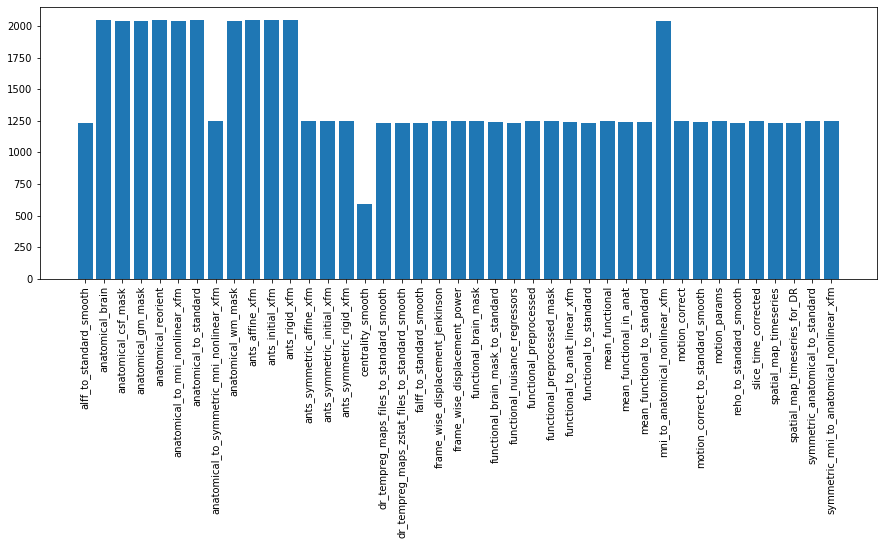

In [158]:
import matplotlib.pyplot as plt

x = list(sorted(derivs.keys()))
y = [len(set(derivs.get(k, []))) for k in sorted(derivs.keys())]

plt.figure(figsize=(15,5))
plt.bar(x, y)
plt.tick_params(axis='x', which='major')
plt.xticks(rotation=90)
plt.show()

In [165]:
with open('derivs.pkl', 'wb') as f:
    pickle.dump(derivs, f)

# Summary Stats

## Demographic/health data

In [198]:
df[(df.age > 25) & df.session.str.startswith('BAS')] \
    .groupby('sex') \
    .agg({
        'age': ['mean', 'median', 'std'],
        'bdi': ['mean', 'median','std'],
        'gds': ['mean', 'median','std'],
        'bp_sys': ['mean', 'median','std'],
        'bp_dys': ['mean', 'median','std'],
    }) \
    .transpose()

sex                     F           M
age    mean     68.673848   68.958462
       median   69.023288   69.202740
       std       2.020741    1.601347
bdi    mean      4.886364    4.193548
       median    3.000000    2.000000
       std       5.507778    5.192426
gds    mean      4.295455    3.548387
       median    3.000000    3.000000
       std       5.232188    3.731297
bp_sys mean    135.090909  139.806452
       median  131.500000  136.000000
       std      23.241721   20.582224
bp_dys mean     76.636364   80.387097
       median   75.500000   80.000000
       std      12.327113   11.152511

In [202]:
sdf = df[(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex', 'age', 'bdi', 'gds', 'bp_sys','bp_dys']] \

sdf_long = pd.melt(sdf, id_vars=['participant', 'sex'], value_vars=['age', 'bdi', 'gds', 'bp_sys','bp_dys'])

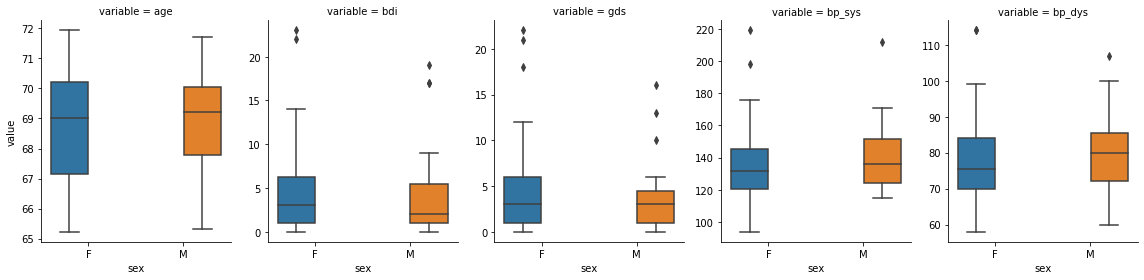

In [212]:
g = sns.catplot(x="sex", y="value",
                hue="sex", col="variable",
                data=sdf_long, kind="box",
                height=4, aspect=.8, sharey=False, legend = True)

## volumetric data

In [215]:
files = []
files = glob.glob('volume_per_freesurfer_label/sub*/tables/*csv')

In [219]:
li = []
for file in files:
    sub=file.split('/')[1].split('_')[0].split('-')[1]
    ses=file.split('/')[1].split('_')[1].split('-')[1]
    
    f = pd.read_csv(file)
    f['participant']=sub
    f['session']=ses
    roiList=[ 'ctx-lh-entorhinal', 'Left-Hippocampus', 'Left-Amygdala', 'ctx-rh-entorhinal', 'Right-Hippocampus', 'Right-Amygdala' ]

    li.append(f[f['name'].isin(roiList)])
    
frame = pd.concat(li, axis=0)
frame.columns = frame.columns.str.lstrip()

In [224]:
frame = frame.merge(df[['participant', 'sex', 'age']], on='participant')


In [234]:
frame.rename(columns={'name':'roi'}, inplace=True)

In [235]:
# print(frame.groupby('name').agg(['mean', 'median', 'std']))

frame[(frame.age > 25)] \
    .groupby(['sex', 'roi']) \
    .agg({
        'volume': ['mean', 'median', 'std'],
    })




volume                      
                              mean    median         std
sex roi                                                 
F   Left-Amygdala      1292.869492  1340.866  200.476519
    Left-Hippocampus   3786.711885  3705.968  298.108895
    Right-Amygdala     1475.287082  1500.130  135.598957
    Right-Hippocampus  3975.476820  3981.590  249.099936
    ctx-lh-entorhinal  2156.194623  2156.258  502.988468
    ctx-rh-entorhinal  2092.564246  2042.770  462.408211
M   Left-Amygdala      1507.337721  1512.527  134.385410
    Left-Hippocampus   4150.922977  4263.878  463.791705
    Right-Amygdala     1747.863209  1715.660  127.722114
    Right-Hippocampus  4307.857767  4354.477  455.298395
    ctx-lh-entorhinal  2719.812628  2562.523  631.285008
    ctx-rh-entorhinal  2607.988744  2650.261  460.079163

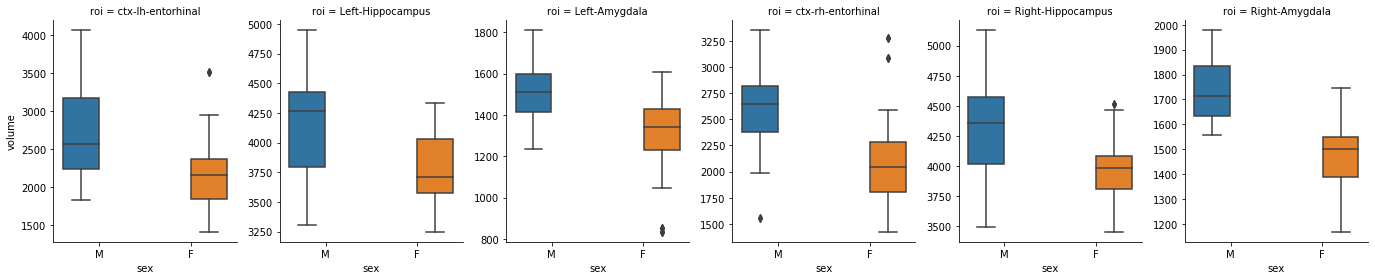

In [236]:
g = sns.catplot(x="sex", y="volume",
                hue="sex", col="roi",
                data=frame, kind="box",
                height=4, aspect=.8, sharey=False, legend = True)